In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# Ramping with I
ISIs = [0.4] * 4
ISI_pts = np.cumsum(ISIs)

# Constants
I0 = 1.5
beta = 1.5
alpha = 5

# Initialize
IS = I0
IP = I0
y0 = 0.7

# For storage
yS_lst = []
IS_lst = []
IP_lst = []
productions = []

# Synchronization
for i in range(len(ISIs)):
    print(i, ISI_pts[i-1])
    # Period adjustment
    yS = IS * ISIs[i]
    IS_new = IS - beta * (yS - y0)
    print('yS = ', yS, 'IS_new = ', IS_new)
    yS_lst.append(yS)
    IS_lst.append(IS_new)
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    # Calculate y_out of SAM
    if i == 0:
        
    print('ISI_i-1 = ', ISI_pts[i-1])
    if ISI_pts[i-1] < np.sum(productions):
        y_out = IS_new * (np.sum(productions) - ISI_pts[i-1])
    else:
        y_out = IS_new * (np.sum(productions) - ISI_pts[i-2])
    
    IP = IS_new + alpha * (y0 - y_out)
    IS = IS_new
    IP_lst.append(IP)
    print('IP = ', IP)
    
    
    
# Continuation
n_continuation = 5
continuation_const = 0.1
for i in range(n_continuation):
    # Period adjustment: IS unchanged since no stimulus is observed
    IS_new = IS
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    IP = IS_new + alpha * (continuation_const)
    IS = IS_new
    IP_lst.append(IP)
    print('IP = ', IP)
    

    








0 1.6
yS =  0.6000000000000001 IS_new =  1.65
tp =   0.4666666666666666
ISI_i-1 =  1.6
IP =  11.200000000000003
1 0.4
yS =  0.66 IS_new =  1.7099999999999997
tp =   0.06249999999999998
ISI_i-1 =  0.4
IP =  4.105625000000001
2 0.8
yS =  0.6839999999999999 IS_new =  1.7339999999999998
tp =   0.17049779266250567
ISI_i-1 =  0.8
IP =  2.6359091376160766
3 1.2000000000000002
yS =  0.6936 IS_new =  1.7435999999999998
tp =   0.2655630234026511
ISI_i-1 =  1.2000000000000002
IP =  3.8031468055439652
tp =   0.18405810656049043
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436


In [8]:
a = [1, 2,3, 4, 5]
a[-2]

4

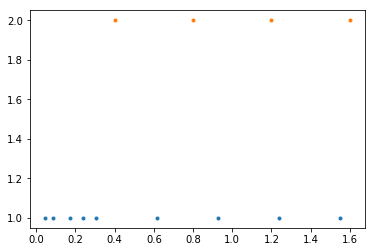

In [4]:
# Plot the result
plt.plot(np.cumsum(productions), np.ones(len(productions)), '.')
plt.plot(ISI_pts, np.ones(len(ISI_pts)) * 2, '.')

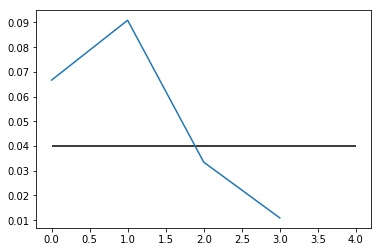

In [68]:
plt.plot(np.cumsum(productions) - ISI_pts)
plt.hlines(0.04, 0, len(ISI_pts))

In [5]:
ISI_pts

array([ 400,  800, 1200, 1600], dtype=int32)

In [44]:
plt.hlines?

## Discrete updating algorithm

### Continuous time definitions
$y_{\textrm{ref}}$ : Reference level

$y_{\textrm{SAM}}$ : Output of SAM

$y_{\textrm{MPM}}$ : Output of of MPM

$I_{\textrm{SAM}}$ : Input to SAM

$I_{\textrm{MPM}}$ : Input to MPM


### Translation into discrete time
$i$ will index *time-points* and *intervals*

$t_p^i$ : time of $i$th production

$t_s^i$ : time of $i$th stimulus

$\textrm{ISI}^i$ = $t_s^{i+1} - t_s^i$

$\textrm{IPI}^i$ = $t_p^{i+1} - t_p^i$

$y_{\textrm{SAM}}^i=I_{\textrm{SAM}}^i*\textrm{ISI}^i$

$I_{\textrm{SAM}}^{i+1}=I_{\textrm{SAM}}^i+\beta(y_{\textrm{ref}}-y_{\textrm{SAM}}^i)$

$I_{\textrm{MPM}}^{i+1} = I_{\textrm{SAM}}^{i+1} + \alpha(y_{\textrm{out}}^i-y_{\textrm{MPM}}^i)$

$\textrm{IPI}^i=y_{\textrm{ref}}/I_{\textrm{MPM}}$

$t_p^{i+1}=t_p^i+\textrm{IPI}^i$

By definition $y_{\textrm{MPM}}^i=y_{\textrm{ref}}$ (output of $y_{\textrm{MPM}}$ at ith production)

The value of $y_{\textrm{out}}^i$ represents the output of the SAM at the time of the $i$th production. During synchronization that will be:

if $t_s^{i}<t_p^i$

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^{i}-t_s^{i})$

else

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^i-t_s^{i-1})$


During continuation:

$y_{\textrm{out}}^i = y_{\textrm{SAM}}^\infty$

with $y_{\textrm{SAM}}^\infty$ representing the terminal output of the SAM module.

In [140]:
# Definitions
def I_s_update(I_s_in,beta,y_ref,y_s):
    I_s_out = I_s_in + beta*(y_ref - y_s)
    
    return I_s_out

def I_p_update(I_s,alpha,y_p,y_out):
    I_p_out = I_s + alpha*(y_out-y_p)
    
    return I_p_out

def discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s)))
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):

        IPI[i] = y_ref/I_p[i]
        if i > 0:
            t_p[i+1] = t_p[i] + IPI[i]
        else:
            t_p[i+1] = IPI[i]

        y_s[i] = I_s[i]*ISI[i]

        I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        if t_s[i] < t_p[i]:
            y_out = I_s[i]*(t_p[i]-t_s[i])
        else:
            if i == 0:
                y_out = y_ref
            else:
                y_out = I_s[i]*(t_p[i]-t_s[i-1])
            #print(i,y_out)


        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        print(t_s[i],t_p[i],IPI[i])
    
    return t_s, t_p, IPI, I_s, I_p, y_s

## Synchronization to a constant ISI

In [147]:
# Simple synchronization
ISI = [0.4] * 50
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.2, alpha=0.1, y_ref=1, I_s_init=1/0.35)

#for i in range(len(t_s)):
#    print(t_s[i],t_p[i],IPI[i])

0.0 0.0 0.35
0.4 0.35 0.353535353535
0.8 0.703535353535 0.356978938243
1.2 1.06051429178 0.361904206453
1.6 1.42241849823 0.366538256556
2.0 1.78895675479 0.370826134496
2.4 2.15978288928 0.374778553378
2.8 2.53456144266 0.378409922469
3.2 2.91297136513 0.381735674128
3.6 3.29470703926 0.384771871412
4.0 3.67947891067 0.387534934289
4.4 4.06701384496 0.390041402322
4.8 4.45705524728 0.392307730735
5.2 4.84936297802 0.39435011884
5.6 5.24371309686 0.39618436911
6.0 5.63989746597 0.397825774609
6.4 6.03772324058 0.399289032109
6.8 6.43701227268 0.400588178056
7.2 6.83760045074 0.401736544487
7.6 7.23933699523 0.40274673208
8.0 7.64208372731 0.403630597645
8.4 8.04571432495 0.404399253594
8.8 8.45011357855 0.405063077126
9.2 8.85517665567 0.405631727145
9.6 9.26080838282 0.406114167139
10.0 9.66692254996 0.406518692524
10.4 10.0734412425 0.406852961163
10.8 10.4802942036 0.40712402597
11.2 10.8874182296 0.407338368733
11.6 11.2947565983 0.4075019344
12.0 11.7022585327 0.40762016527
12.4 1

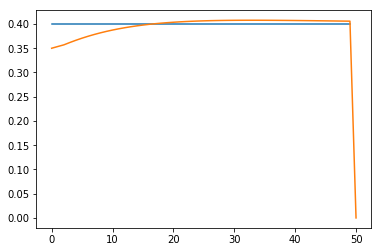

In [148]:
plt.plot(ISI)
plt.plot(IPI)

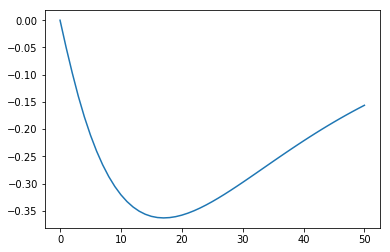

In [149]:
plt.plot(t_p-t_s)